In [2]:
!pip install -q kaggle
!pip install segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from google.colab import files
upload = files.upload()

Saving kaggle.json to kaggle.json


In [4]:
#!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download -d tapakah68/supervisely-filtered-segmentation-person-dataset

100% 4.29G/4.31G [01:03<00:00, 89.6MB/s]
100% 4.31G/4.31G [01:03<00:00, 72.3MB/s]


In [6]:
! unzip supervisely-filtered-segmentation-person-dataset

Streaming output truncated to the last 5000 lines.
  inflating: supervisely_person_clean_2667_img/images/ds2_person-human-female-girl.png  
  inflating: supervisely_person_clean_2667_img/images/ds2_person-woman-coffee-cup.png  
  inflating: supervisely_person_clean_2667_img/images/ds2_person-woman-eyes-face.png  
  inflating: supervisely_person_clean_2667_img/images/ds2_person-woman-hotel-laptop.png  
  inflating: supervisely_person_clean_2667_img/images/ds2_pexels-photo-105472.png  
  inflating: supervisely_person_clean_2667_img/images/ds2_pexels-photo-123318.png  
  inflating: supervisely_person_clean_2667_img/images/ds2_pexels-photo-125522.png  
  inflating: supervisely_person_clean_2667_img/images/ds2_pexels-photo-12628.png  
  inflating: supervisely_person_clean_2667_img/images/ds2_pexels-photo-127901.png  
  inflating: supervisely_person_clean_2667_img/images/ds2_pexels-photo-134068.png  
  inflating: supervisely_person_clean_2667_img/images/ds2_pexels-photo-136673.png  
  inflat

In [7]:
#data.py
import os
import numpy as np
import cv2
from glob import glob
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt

def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (256, 256))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (256, 256))
    x = x/255.0
    x = x > 0.5
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)
    return x

def load_dataset(dataset_path):
    images = glob(os.path.join(dataset_path, "/content/supervisely_person_clean_2667_img/images/*"))
    masks = glob(os.path.join(dataset_path, "/content/supervisely_person_clean_2667_img/masks/*"))

    train_x, test_x = train_test_split(images, test_size=0.2, random_state=42)
    train_y, test_y = train_test_split(masks, test_size=0.2, random_state=42)

    return (train_x, train_y), (test_x, test_y)

def preprocess(image_path, mask_path):
    def f(image_path, mask_path):
        image_path = image_path.decode()
        mask_path = mask_path.decode()

        x = read_image(image_path)
        y = read_mask(mask_path)

        return x, y

    image, mask = tf.numpy_function(f, [image_path, mask_path], [tf.float32, tf.float32])
    image.set_shape([256, 256, 3])
    mask.set_shape([256, 256, 1])

    return image, mask

def tf_dataset(images, masks, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((images, masks))
    dataset = dataset.shuffle(buffer_size=5000)
    dataset = dataset.map(preprocess)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(2)
    return dataset

if __name__ == "__main__":
    dataset_path = "people_segmentation"
    (train_x, train_y), (test_x, test_y) = load_dataset(dataset_path)
    print(f"Train: {len(train_x)} - {len(train_y)}")
    print(f"Test: {len(test_x)} - {len(test_y)}")

    train_dataset = tf_dataset(train_x, train_y, batch=8)

    # for images, masks in train_dataset:
    #     print(images.shape, masks.shape)

    ## 10 - 3
    ## 10//3 = 3
    ## 3 * 3 = 9
    ## 3 + 1

    # train_steps = len(train_x)//8
    # if len(train_x) % 8 != 0:
    #     train_steps += 1
    #
    # print(f"Train Steps: {train_steps}")

Train: 2133 - 2133
Test: 534 - 534


In [8]:
#model.py
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model

if __name__ == "__main__":
    input_shape = (512, 512, 3)
    model = build_unet(input_shape)
    model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

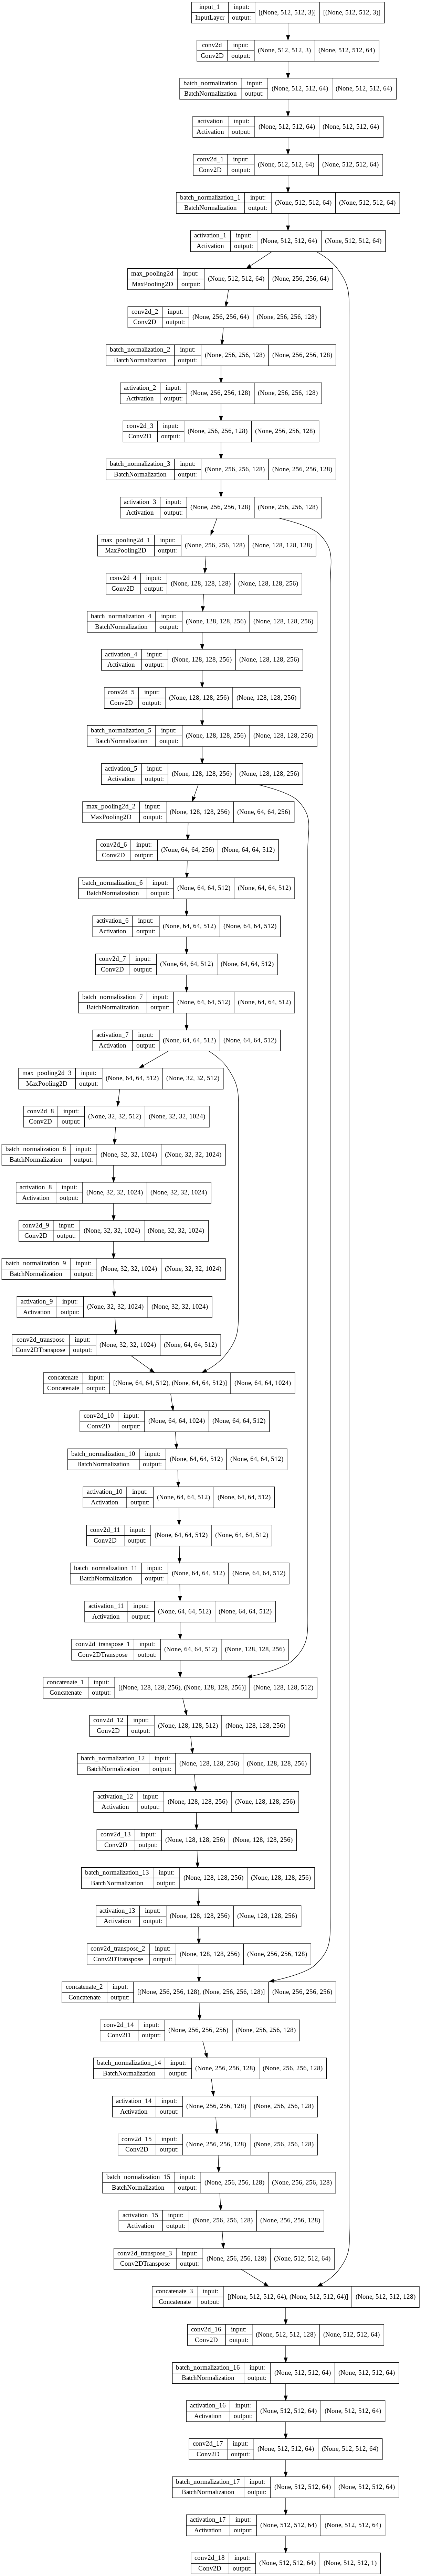

In [9]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [10]:
#train.py
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import tensorflow as tf
#from model import build_unet
#from data import load_dataset, tf_dataset
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping

if __name__ == "__main__":
    """ Hyperparamaters """
    dataset_path = "people_segmentation"
    input_shape = (256, 256, 3)
    batch_size = 12
    epochs = 9
    lr = 1e-4
    model_path = "unet.h5"
    csv_path = "data.csv"

    """ Load the dataset """
    (train_x, train_y), (test_x, test_y) = load_dataset(dataset_path)
    print(f"Train: {len(train_x)} - {len(train_y)}")
    print(f"Test: {len(test_x)} - {len(test_y)}")

    train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
    test_dataset = tf_dataset(test_x, test_y, batch=batch_size)

    """ Model """
    model = build_unet(input_shape)
    model.compile(
        loss="binary_crossentropy",
        optimizer=tf.keras.optimizers.Adam(lr),
        metrics=[
            tf.keras.metrics.MeanIoU(num_classes=2),
            tf.keras.metrics.Recall(),
            tf.keras.metrics.Precision(),
             tf.keras.metrics.Accuracy()
        ]
    )

    # model.summary()

    callbacks = [
        ModelCheckpoint(model_path, monitor="val_loss", verbose=1),
        ReduceLROnPlateau(monitor="val_loss", patience=5, factor=0.1, verbose=1),
        CSVLogger(csv_path),
        EarlyStopping(monitor="val_loss", patience=10)
    ]

    train_steps = len(train_x)//batch_size
    if len(train_x) % batch_size != 0:
        train_steps += 1

    test_steps = len(test_x)//batch_size
    if len(test_x) % batch_size != 0:
        test_steps += 1

    model.fit(
        train_dataset,
        validation_data=test_dataset,
        epochs=epochs,
        steps_per_epoch=train_steps,
        validation_steps=test_steps,
        callbacks=callbacks
    )

Train: 2133 - 2133
Test: 534 - 534
Epoch 1/9
178/178 [==============================] - ETA: 0s - loss: 0.4711 - mean_io_u: 0.3436 - recall: 0.6696 - precision: 0.6572 - accuracy: 5.0345e-04
Epoch 1: saving model to unet.h5
178/178 [==============================] - 236s 1s/step - loss: 0.4711 - mean_io_u: 0.3436 - recall: 0.6696 - precision: 0.6572 - accuracy: 5.0345e-04 - val_loss: 0.9185 - val_mean_io_u: 0.3388 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_accuracy: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/9
178/178 [==============================] - ETA: 0s - loss: 0.3444 - mean_io_u: 0.3448 - recall: 0.7461 - precision: 0.7780 - accuracy: 0.0011
Epoch 2: saving model to unet.h5
178/178 [==============================] - 187s 1s/step - loss: 0.3444 - mean_io_u: 0.3448 - recall: 0.7461 - precision: 0.7780 - accuracy: 0.0011 - val_loss: 0.4250 - val_mean_io_u: 0.3388 - val_recall: 0.5573 - val_precision: 0.7937 - val_accuracy: 0.0000e+00 - lr: 1.0000e-04
Epoch 3/9
178/178 [==

In [22]:
#test.py
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow as tf
import numpy as np
import cv2
from glob import glob
from tqdm import tqdm

if __name__ == "__main__":
    """ Load the test images """
    test_images = glob("/content/images/*")

    """ Load the model """
    model = tf.keras.models.load_model("unet.h5")

    for path in tqdm(test_images, total=len(test_images)):
        x = cv2.imread(path, cv2.IMREAD_COLOR)
        original_image = x
        h, w, _ = x.shape

        x = cv2.resize(x, (256, 256))
        x = x/255.0
        x = x.astype(np.float32)

        x = np.expand_dims(x, axis=0)
        pred_mask = model.predict(x)[0]

        pred_mask = np.concatenate(
            [
                pred_mask,
                pred_mask,
                pred_mask
            ], axis=2)
        pred_mask = (pred_mask > 0.5) * 255
        pred_mask = pred_mask.astype(np.float32)
        pred_mask = cv2.resize(pred_mask, (w, h))

        original_image = original_image.astype(np.float32)

        alpha = 0.6
        cv2.addWeighted(pred_mask, alpha, original_image, 1-alpha, 0, original_image)

        name = path.split("/")[-1]
        cv2.imwrite(f"/content/save_images/{name}", original_image)

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


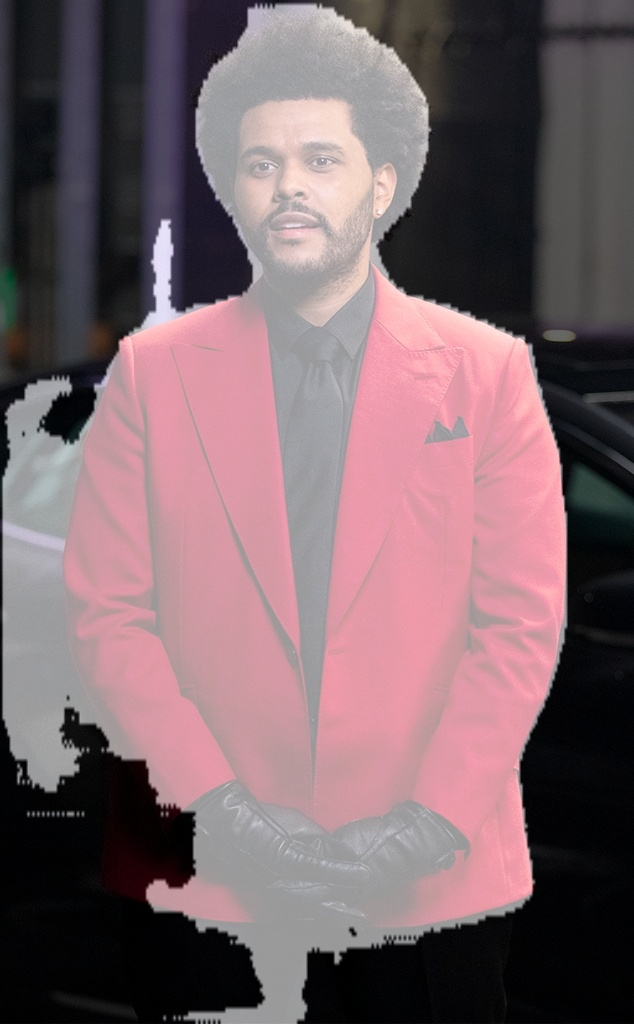

In [23]:
import glob
from IPython.display import Image, display

imagepath = '/content/save_images/*'
for image in glob.glob(imagepath):
    display(Image(image))